# Create low Poly images by randomly generating triangles on images an average over their pixels

This notebook improves the horrendous first attempt to create low poly images utilizing Dulaunay method on randomly generated coordinates. 
It is not meant to be performant as it is just a little project. 

First, lets take a look at the original image.

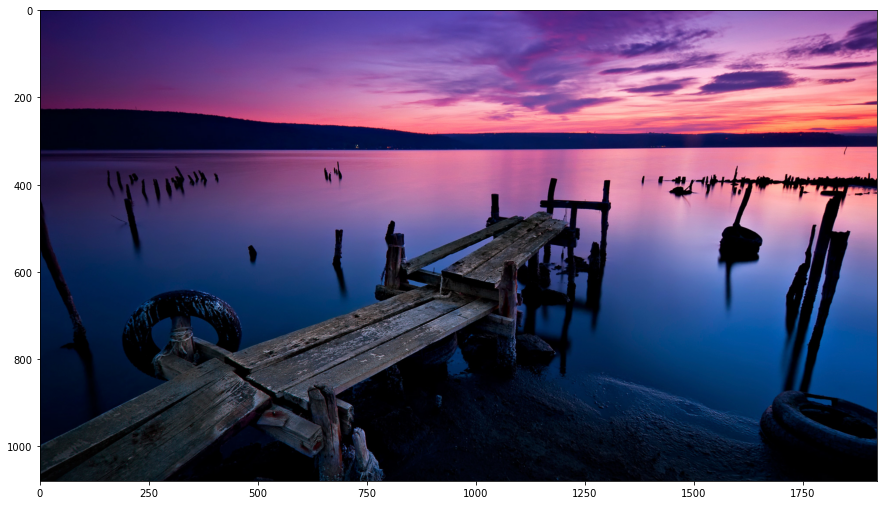

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

image_path = "images/test_image.jpg"

img_orig = plt.imread(image_path)
# img_orig = plt.imread(r"C:\Users\chris\Dropbox\sonstiges\Wallpaper\ddm6tx0-37455dc5-4ad2-41e4-9d13-151d0c6747e8.png")
plt.imshow(img_orig); plt.show()

Image shape: (1080, 1920, 3)


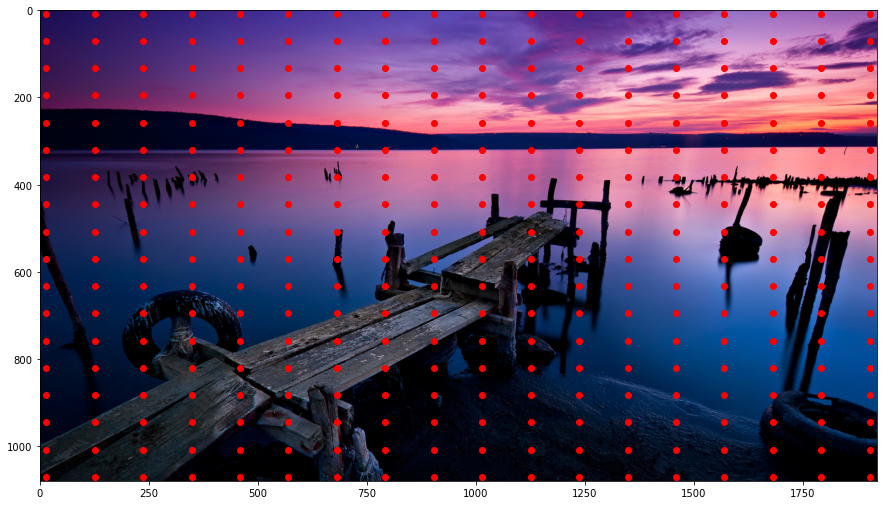

In [2]:
import numpy as np
import cv2

n_points_per_dim = 20
over_edge_factor = 0.05

height, width = img_orig.shape[:2]
print("Image shape:", img_orig.shape)
x = np.linspace(-width*over_edge_factor, width-1 + width*over_edge_factor, n_points_per_dim, dtype=int)
y = np.linspace(-height*over_edge_factor, height-1 + height*over_edge_factor, n_points_per_dim, dtype=int)
xx,yy = np.meshgrid(x,y)
xx,yy = xx.ravel(), yy.ravel()
coords = np.array([xx,yy]).T

img = img_orig.copy()
plt.imshow(img)
plt.plot(coords[:,0], coords[:,1], "ro")
plt.imshow(img); plt.show()

As this grid is quite boring and (probably) would not produce a nice image, we apply a little randomness to the coordinates. In this case we just use np.random.normal, but there are many other ways to do this. Keep in mind to apply this to xx and yy, as we would get a "structured randomness" otherwise.

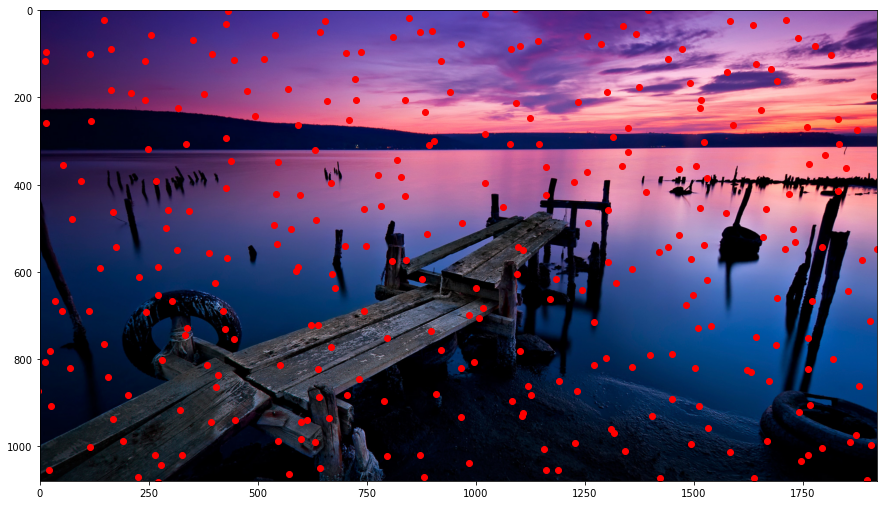

In [3]:
xx += np.random.normal(0,width//n_points_per_dim / 2, size=xx.shape).astype(int)
yy += np.random.normal(0,height//n_points_per_dim / 2, size=yy.shape).astype(int)
coords = np.array([xx,yy]).T

img = img_orig.copy()
plt.imshow(img)
plt.plot(coords[:,0], coords[:,1], "ro")
plt.imshow(img); plt.show()


Now comes the difficult part: Generate good triangles using the generated coordinates. "Difficult" as in someone had to implement it, we just import it from scipy....

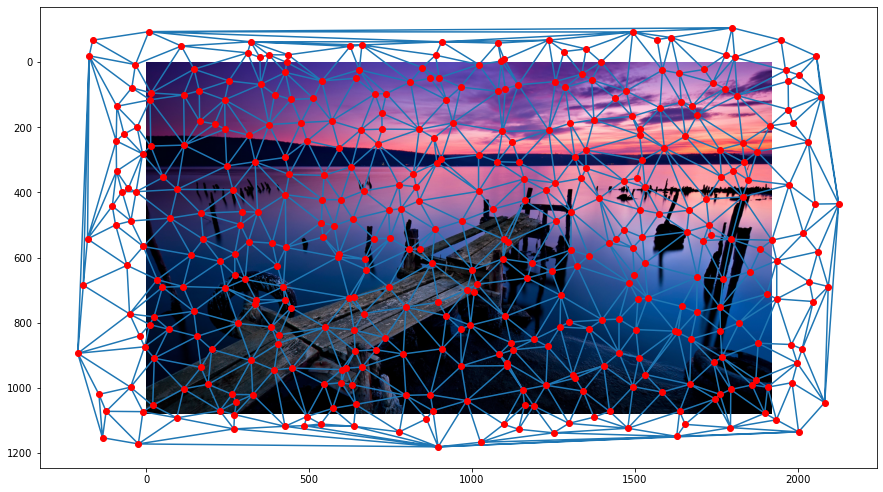

In [4]:
from scipy.spatial import Delaunay

tri = Delaunay(coords)
plt.imshow(img)
plt.triplot(coords[:,0], coords[:,1], tri.simplices)
plt.plot(coords[:,0], coords[:,1], 'ro')
plt.show()

While this looks quite fancy already, we now need to compute the contents of the triangles to generate. To do this, we first need to get all points (and their colors in the image) within a given triangle. As this is quite annoying to compute ourselfes, just use this answer from StackOverflow https://stackoverflow.com/a/45731214.  

This cell is not needed if you use the much faster mahotas method.

In [5]:
# from time import time
# from matplotlib.path import Path

# def getPointsInPoly(tupVerts, width, height):
#     x, y = np.meshgrid(np.arange(width), np.arange(height)) # make a canvas with coordinates
#     x, y = x.flatten(), y.flatten()
#     points = np.vstack((x,y)).T 

#     p = Path(tupVerts) # make a polygon
#     grid = p.contains_points(points)
#     mask = grid.reshape(height, width) # now you have a mask with points inside a polygon

#     return mask

# t0 = time()
# for triangle in tri.simplices:
#     tri_coords = np.array([coords[i] for i in triangle], dtype=int)
#     mask = getPointsInPoly(tri_coords, width, height)
#     # print(tri_coords)
#     # print(mask.shape, "Num of positive pixels:",np.sum(mask))
# print(time() - t0)

As this method is fairly slow, an alternativ method using the package mahotas is implemented and tested. Should generate mostly the same results.

In [6]:
from mahotas.polygon import fill_polygon
from time import time

def getPointsInPolyMahotas(verts, width, height):
    xmin_offset = abs(min(min([v[0] for v in verts]), 0))
    xmax_offset = abs(max(max([v[0] for v in verts]), width) - width)
    ymin_offset = abs(min(min([v[1] for v in verts]), 0))
    ymax_offset = abs(max(max([v[1] for v in verts]), height) - height)

    grid = np.zeros((xmin_offset + width + xmax_offset,
                     ymin_offset + height + ymax_offset), 
                    dtype=np.int8)
    mod_verts = [[v[0]+xmin_offset, v[1]+ymin_offset] for v in verts]

    fill_polygon(mod_verts, grid)
    grid = grid>0 # convert from int ot bool
    return grid[xmin_offset:width+xmin_offset, ymin_offset:height+ymin_offset].T

t0 = time()
for triangle in tri.simplices:
    tri_coords = np.array([coords[i] for i in triangle], dtype=int)
    # print(tri_coords)
    mask = getPointsInPolyMahotas(tri_coords, width, height)
    # print(mask.shape, "Num of positive pixels:",np.sum(mask))
print(time() - t0)

1.6334691047668457


Now we need to get all the colors from the mask, simply by using average over the image coordinates and generate a new image.  
To use the matplotlib.Path method the generate the pixels of a polygon, set use_mahotas to False.  

In [7]:
use_mahotas = True

img = np.ones(shape=(img_orig.shape), dtype=int) + np.average(img_orig, axis=(0,1)).astype(int)

for triangle in tri.simplices:
    tri_coords = np.array([coords[i] for i in triangle], dtype=int)
    if use_mahotas:
        mask = getPointsInPolyMahotas(tri_coords, width, height)
    else:
        mask = getPointsInPoly(tri_coords, width, height)

    if np.sum(mask) > 0:
        img[mask] = np.mean(img_orig[mask], axis=0)

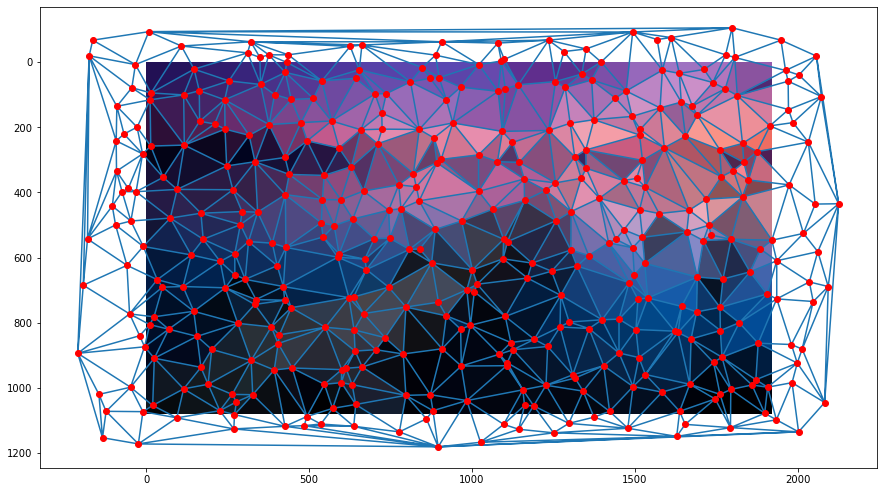

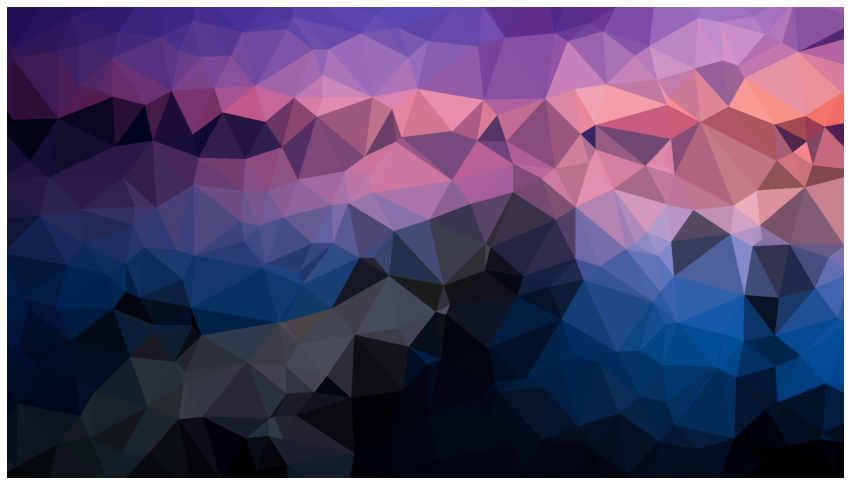

In [8]:
plt.imshow(img)
plt.triplot(coords[:,0], coords[:,1], tri.simplices)
plt.plot(coords[:,0], coords[:,1], 'ro')
plt.show()

plt.imshow(img); plt.axis("off")
plt.show()

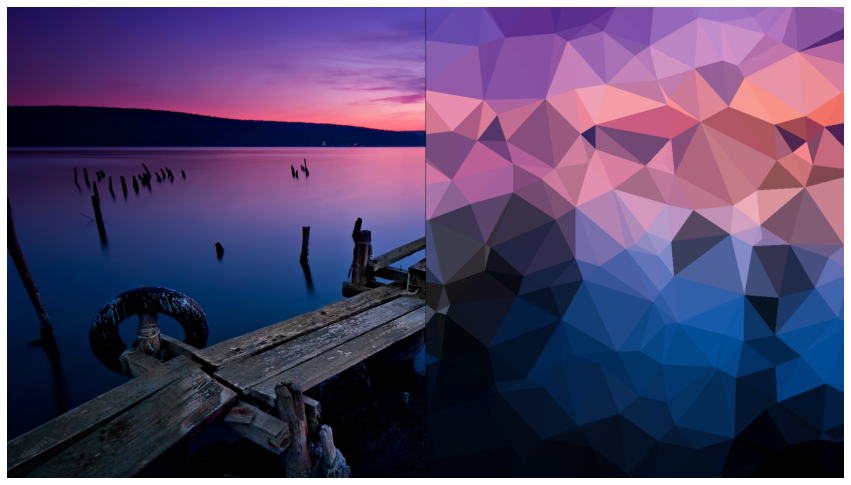

In [9]:
img_comp = img_orig.copy()
img_comp[:, -width//2:] = img[:,-width//2:]
img_comp[:, width//2, :3] = [0, 0, 0]
plt.imshow(img_comp); plt.axis("off")
plt.show()

In [10]:
import cv2

path_splt = image_path.split(".")
cv2.imwrite(".".join(path_splt[:-1]) + "-lp." + path_splt[-1], img[:,:,::-1])
cv2.imwrite(".".join(path_splt[:-1]) + "-comp." + path_splt[-1], img_comp[:,:,::-1])

True